<a href="https://colab.research.google.com/github/kseohyuz/Toi_testcode/blob/main/toi_week3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# < ToI week3: 데이터 전처리 >

*   데이터셋 탐색
    * 데이터셋 다운로드
    * 데이터셋 확인
    * 바운딩 박스 도식화
*   데이터 전처리
    * Augmentation 실습
          1. Torchvision Transforms
          2. Albumentations
          3. 확률 기반 Augmentation 조합
    * 바운딩 박스 Augmentation
    * 데이터 분리

## **데이터셋 탐색**
목적 : 데이터셋 탐색을 하여 바운딩 박스를 확인하는 실습

### **데이터셋 다운로드**

In [ ]:
# Tutorial-Book-Utils 저장소를 Colab 환경에 다운로드
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils

Cloning into 'Tutorial-Book-Utils'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 45 (delta 18), reused 17 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (45/45), 11.62 KiB | 5.81 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [ ]:
# --data 파라미터로 마스크 착용 탐지 모델 구축에 활용할 데이터 지정
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection

Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=28200fd0-1cdf-4bcf-9104-b2755351fcfe
To: /content/Face Mask Detection.zip
100% 417M/417M [00:07<00:00, 53.2MB/s]
Face Mask Detection.zip download complete!


In [ ]:
# 압축파일 해제
!unzip -q Face\ Mask\ Detection.zip

###**데이터셋 확인**

Face Mask Detection 데이터셋 확인과정

1. 폴더 안 데이터 파일 확인
“images”와 “annotations” 두 폴더가 존재하고,
“images” 폴더에는 이미지 파일이 0부터 852까지 있으며, “annotations” 폴더에는 xml 파일이 0부터 852까지 있다.

2. 이미지 파일 정보 확인
“annotations” 폴더 안에 있는 xml 파일들은 각각의 이미지 파일의 정보를 가지고 있다.
  - 이미지 위치 폴더명, 파일명
  - 이미지 크기 정보
  - object 안 코드 정보 (4가지 확인 가능)
    -  mask_weared_incorrect: 마스크를 제대로 쓰지 않은 객체의 정보
    -  with_mask: 마스크를 착용하고 있는 객체 위치 정보
    -  without_mask: 마스크를 쓰지 않은 객체의 정보
    -  bndbox: xmin, ymin, xmax, ymax가 순서대로 나오는 것을 확인. 바운딩 박스 영역을 지정하는 정보

3. xml 파일이 png 이미지 파일로 시각화한 것을 확인

### **바운딩 박스 도식화**


In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

In [ ]:
# glob 패키지로 데이터셋 불러옴
# sorted 함수로 id 순서 같도록 맞춤
img_list = sorted(glob.glob('/content/images/*.png'))
annot_list = sorted(glob.glob('/content/annotations/*.xml'))

In [ ]:
# 각 폴더에 들어있는 파일 갯수 파악
print(len(img_list))
print(len(annot_list))

853
853


In [ ]:
# 바운딩 박스 영역 bndbox 값을 반환하는 함수

def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]


# 마스크 착용 여부를 세단계로 나눠서 0,1,2값으로 반환하는 함수

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0


# generate_box와 generate_label를 각각 호출하여 반환된 값을 딕셔너리에 저장해 반환하는 함수

def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

# 이미지와 바운딩박스를 함께 시각화하는 함수

def plot_image(img_path, annotation):

    img = mpimg.imread(img_path)

    fig,ax = plt.subplots(1)
    ax.imshow(img)


    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 1 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
img_list.index('/content/images/maksssksksss307.png')

232

In [ ]:
!pip install torch
import torch

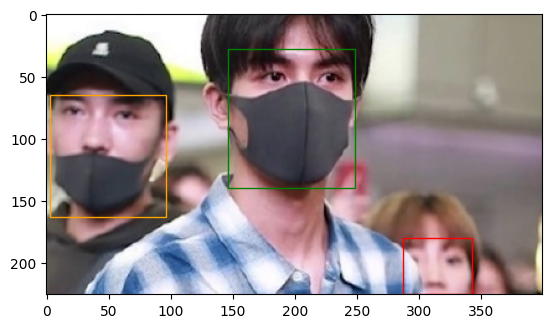

In [ ]:
bbox = generate_target(annot_list[232])
plot_image(img_list[232], bbox)

## **데이터 전처리**

### **Augmentation 실습**

In [ ]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.
Downloading...
From (original): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7
From (redirected): https://drive.google.com/uc?id=16Gzn1w38yZLJpzmzKcRIRveFeHZtCEr7&confirm=t&uuid=8fd6faf5-cfea-467e-9498-45068bd1405c
To: /content/Face Mask Detection.zip
100% 417M/417M [00:09<00:00, 46.1MB/s]
Face Mask Detection.zip download complete!
replace annotations/maksssksksss0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install --upgrade albumentations

In [ ]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def generate_box(obj):

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)

    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0


def generate_target(file):
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels

        return target

def plot_image_from_output(img, annotation):

    img = img.permute(1,2,0)

    fig,ax = plt.subplots(1)
    ax.imshow(img)

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')

        elif annotation['labels'][idx] == 1 :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')

        else :

            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

1.torchvision.transforms

transforms 적용 전


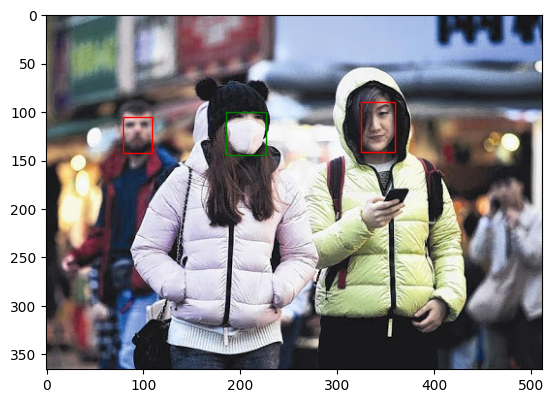

In [ ]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            img = self.transform(img)

        total_time = (time.time() - start_t)

        return img, target, total_time
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path = 'images/',
    transform = torchvision_transform
)
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = 'images/',
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print('transforms 적용 전')
plot_image_from_output(img, annot)

transforms 적용 후


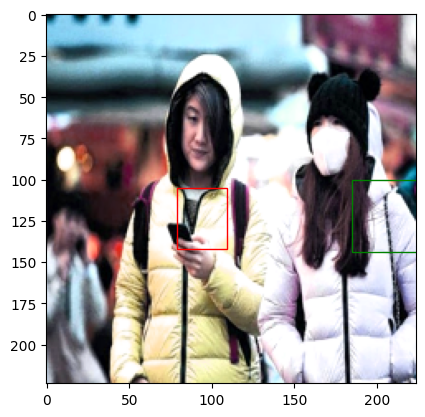

In [ ]:
img, annot, transform_time = torchvision_dataset[0]

print('transforms 적용 후')
plot_image_from_output(img, annot)

In [ ]:
#  torchvision.transforms을 100번 적용시킨뒤 시간을 측정
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

torchvision time: 11.910977363586426 ms


2. albumentation

In [ ]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)


        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']


        return image, target, total_time


albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1),
    albumentations.HorizontalFlip(p=1),
    albumentations.pytorch.ToTensorV2()
])

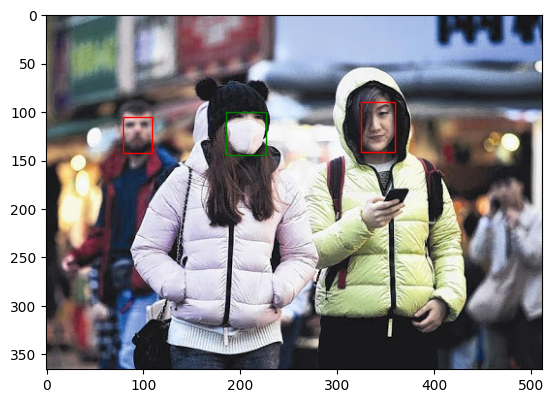

In [ ]:
# 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

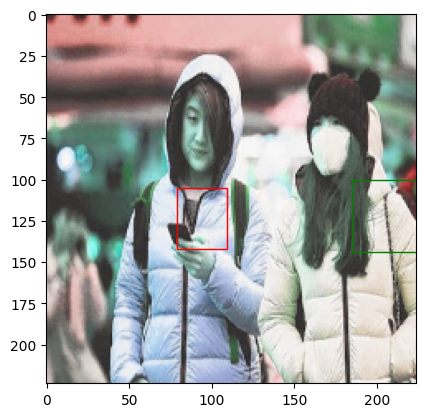

In [ ]:
# 변경 후
albumentation_dataset = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

In [ ]:
# albumentation을 100번 적용 시킨 뒤 시간을 측정
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 2.329387664794922 ms


3. 확률 기반 Augmentation 조합

In [ ]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300),
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)
    ], p=1),
    albumentations.pytorch.ToTensorV2()
])

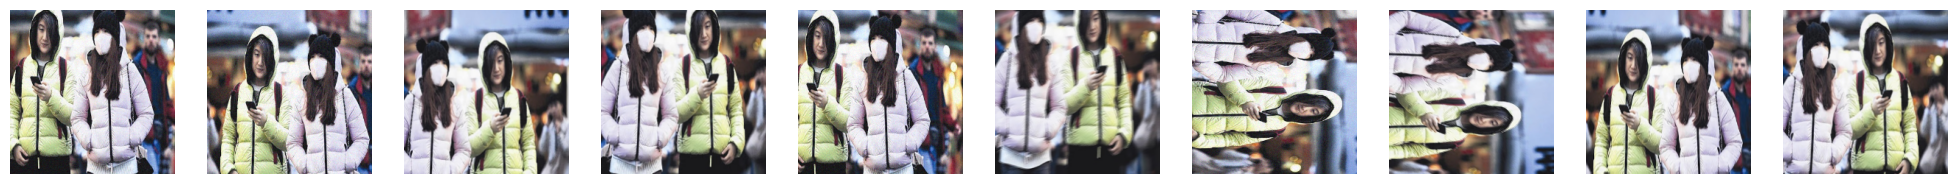

In [ ]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

In [ ]:
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset_oneof[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 11.803507804870605 ms


### **바운딩 박스 Augmentation**

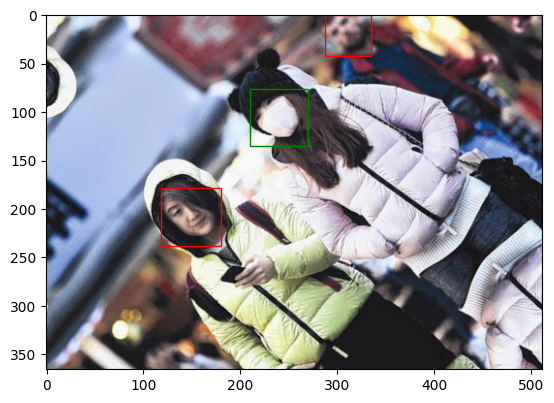

In [ ]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)


        target['labels'] = target['labels'].tolist()

        if self.transform:
            transformed = self.transform(image=image, bboxes=target['boxes'], labels=target['labels'])
            image = transformed['image']
            target = {'boxes': transformed['bboxes'], 'labels': transformed['labels']}

        return image, target


bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

### **데이터 분리**

In [ ]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

853
853


In [ ]:
!mkdir test_images
!mkdir test_annotations

In [ ]:
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [ ]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

683
683
170
170


In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import Counter

def get_num_objects_for_each_class(dataset):

    total_labels = []

    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)


train_data =  BboxAugmentationDataset(
    path = 'images/'
)

test_data =  BboxAugmentationDataset(
    path = 'test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

100%|██████████| 170/170 [00:04<00:00, 39.09it/s]


 train 데이터에 있는 객체 Counter({1: 2691, 0: 532, 2: 97})

 test 데이터에 있는 객체 Counter({1: 541, 0: 185, 2: 26})


# 모델 실습 : RetinaNet